In [1]:
from pymongo import MongoClient
import logging

# Configure logging
logging.basicConfig(filename='analysis_log.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

client = MongoClient("mongodb://localhost:27017/")
db = client.bachelor

reports_count = db.reports.count_documents({})
packages_count = db.packages.count_documents({})
# Wie viele Berichte gibt es?
print(f"Anzahl der Berichte: {reports_count}")
# Wie viele Pakete gibt es?
print(f"Anzahl der Pakete: {packages_count}")

Anzahl der Berichte: 7709
Anzahl der Pakete: 14257


In [2]:
from statistics import median, mean, stdev
# Official vs unofficial packages
official_vulnerabilities = []
unofficial_vulnerabilities = []

for package in db.packages.find({}):
    if "security_report_summary" in package and package['security_report_summary']:
        total_vulnerabilities = 0
        for severity in package['security_report_summary'].values():
            total_vulnerabilities += severity
            
        if package['repository']['official']:
            official_vulnerabilities.append(total_vulnerabilities)
        else:
            unofficial_vulnerabilities.append(total_vulnerabilities)

avg_official = mean(official_vulnerabilities)
avg_unofficial = mean(unofficial_vulnerabilities)

median_official = median(official_vulnerabilities)
median_unofficial = median(unofficial_vulnerabilities)

stdev_official = stdev(official_vulnerabilities)
stdev_unofficial = stdev(unofficial_vulnerabilities)

print (f"Durchschnittliche Anzahl von Schwachstellen in offiziellen Paketen: {avg_official}")
print (f"Durchschnittliche Anzahl von Schwachstellen in inoffiziellen Paketen: {avg_unofficial}")
print (f"Median Anzahl von Schwachstellen in offiziellen Paketen: {median_official}")
print (f"Median Anzahl von Schwachstellen in inoffiziellen Paketen: {median_unofficial}")
print (f"Standardabweichung Anzahl von Schwachstellen in offiziellen Paketen: {stdev_official}")
print (f"Standardabweichung Anzahl von Schwachstellen in inoffiziellen Paketen: {stdev_unofficial}")
print (f"Anzahl offizieller Pakete: {len(official_vulnerabilities)}")
print (f"Anzahl inoffizieller Pakete: {len(unofficial_vulnerabilities)}")


Durchschnittliche Anzahl von Schwachstellen in offiziellen Paketen: 322.5974025974026
Durchschnittliche Anzahl von Schwachstellen in inoffiziellen Paketen: 554.4443177499049
Median Anzahl von Schwachstellen in offiziellen Paketen: 96
Median Anzahl von Schwachstellen in inoffiziellen Paketen: 135
Standardabweichung Anzahl von Schwachstellen in offiziellen Paketen: 718.118012947371
Standardabweichung Anzahl von Schwachstellen in inoffiziellen Paketen: 1338.3093927648047
Anzahl offizieller Pakete: 77
Anzahl inoffizieller Pakete: 7893


In [ ]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(official_vulnerabilities, unofficial_vulnerabilities, alternative='two-sided')

print(f"Mann-Whitney U Test: stat={stat}, p={p}")

Mann-Whitney U Test: stat=255944.5, p=0.017037870956289246


Anzahl der Helm Charts mit Schwachstellen Scan: 5450


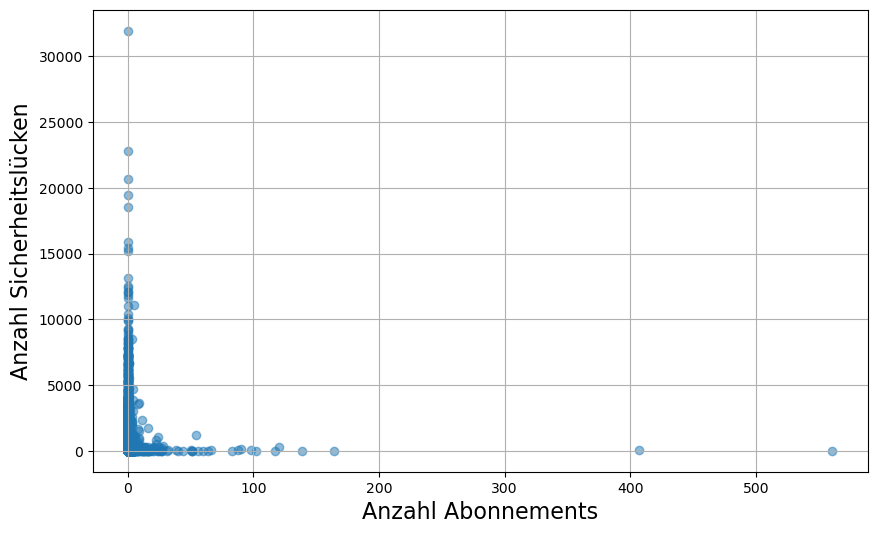

In [16]:
import matplotlib.pyplot as plt
# Beliebtheit vs Schwachstellenanzahl

helm_charts = {}

for package in db.packages.find({}):
    if "security_report_summary" in package:
        total_vulnerabilities = 0
        for severity in package['security_report_summary'].values():
            total_vulnerabilities += severity

        subscriptions = int(package["stats"]["subscriptions"])

        if subscriptions < 0:
            continue

        helm_charts[package['name']] = {
            'vulnerabilities': total_vulnerabilities,
            'subscriptions': subscriptions
        }

print(f"Anzahl der Helm Charts mit Schwachstellen Scan: {len(helm_charts)}")

# Plotting the data
subscriptions = [chart["subscriptions"] for chart in helm_charts.values()]
vulnerabilities = [chart["vulnerabilities"] for chart in helm_charts.values()]

plt.figure(figsize=(10, 6))
plt.scatter(subscriptions, vulnerabilities, alpha=0.5)
plt.xlabel("Anzahl Abonnements", fontsize=16)
plt.ylabel("Anzahl Sicherheitslücken", fontsize=16)
plt.grid(True)
plt.show()


In [17]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p = pearsonr(subscriptions, vulnerabilities)
spearman_corr, spearman_p = spearmanr(subscriptions, vulnerabilities)

print(f"Pearson-Korrelation: {pearson_corr:.3f} (p-Wert: {pearson_p:.3f})")
print(f"Spearman-Korrelation: {spearman_corr:.3f} (p-Wert: {spearman_p:.3f})")

Pearson-Korrelation: -0.023 (p-Wert: 0.084)
Spearman-Korrelation: -0.091 (p-Wert: 0.000)
